# NTHMP2: Hilo 2011

This test aims to reproduce the observation of a tsunami wave reaching and entering the Hilo harbour in Hawai.
The test case is the second of the benchmak problems proposed at the [2015 NTHMP workshop](http://coastal.usc.edu/currents_workshop/problems/prob1.html).

## Pyton set-up

As this notebook is based on Python, please installed the dependencies listed in the \*.yml file: *BG_flood_testing.yml* .

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from scipy import interpolate
from scipy.interpolate import LinearNDInterpolator
from zipfile import ZipFile
from io import BytesIO
import urllib.request

import xarray as xr
import os
import shutil
from netCDF4 import Dataset
import netCDF4 as nc4
import utm

## Read text file given its name (and path), number of columns, number of header lines
def readCSV_Ncol(name,n_col,n_pass):
    X=[]
    for i in range(n_col):
        X.append([])

    f=open(name,'r')
    n_line=0
    for line in f.readlines():
        if n_line<n_pass:
            n_line = n_line+1
        else:
            sline=line.split()
            for i in range(n_col):
                X[i].append(float(sline[i]))
    f.close()
    return(X)

## Download from url
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

MyDir = os.getcwd()

In [2]:
#os.chdir('.\\2_Hilo_2011_Field')

In [3]:
MyDir = os.getcwd()

### Location of the code executable
The variable codeDir contains a compiled version of the BG_Flood (*BG\_Flood.exe*) and the associated needed links to the libraries (\*.dll files)

In [4]:
codeDir = r"C:\Users\haranga\BG-Flood\Test_Cases_Alice\CodeDir"

### Getting the benchmark data from online website
The Benchmark data is located in a [zip](http://coastal.usc.edu/currents_workshop/all_data.zip) on the benchmark website.

In [5]:
download_url('http://coastal.usc.edu/currents_workshop/all_data.zip', 'all_data.zip')

In [6]:
with ZipFile('all_data.zip', 'r') as zipObj:
   # Get a list of all archived file names from the zip
   listOfFileNames = zipObj.namelist()

In [7]:
with ZipFile('all_data.zip', 'r') as zipObj:
    zipObj.extract('2_Hilo_2011_Field/bathy/hilo_grid_1_3_arcsec.txt')
    zipObj.extract('2_Hilo_2011_Field/incident_wave/se.dat')
    zipObj.extract('2_Hilo_2011_Field/comparison_data/TG_1617760_detided.txt')
    zipObj.extract('2_Hilo_2011_Field/comparison_data/HAI1125_detided_harmonic.txt')
    zipObj.extract('2_Hilo_2011_Field/comparison_data/HAI1126_detided_harmonic.txt')

In [8]:
dataDir = os.path.join(MyDir,'2_Hilo_2011_Field')

## Preparation of the bathymetry
The bathymetry is given on a longitude / latitude coordinate system. As the BG_flood is expecting a grid in meter, this file is read, interpolated in the UTM coordinate system and saved in netcdf format.

### Reading the bathymetry file

In [9]:
bathyfile = os.path.join(dataDir,'bathy','hilo_grid_1_3_arcsec.txt')
[lon,lat,Zdeg] = readCSV_Ncol(bathyfile,3,0)

### Projection in the UTM coordinate system
The longitude is first modified to be defined on the [-180;180] interval instead of the inital [0;360].
The y-direction needs to be inverted (to obtain the real Hilo Harbour topography).

In [10]:
x_utm=[]
y_utm=[]
for (x, y) in zip(lon, lat):
    if x>180:
        x=x-360
    [utm_east, utm_north, utm_zone, utm_letter] = utm.from_latlon(y, x)
    x_utm.append(utm_east)
    y_utm.append(-utm_north)

### Interpolation on a square grid
The bathymetry is now interpolated to a square grid (in $m$), slightly smaller than the initial domain in spherical coordinate.

In [11]:
xo=280000
xf=286700
yf=-2181000
yo=-2187600
Dx=xf-xo
Dy=abs(yf-yo)

Text(0.5, 1.0, 'Rectangular domain in plane coordinate (red rectangle) compare to the initial domain (blue)')

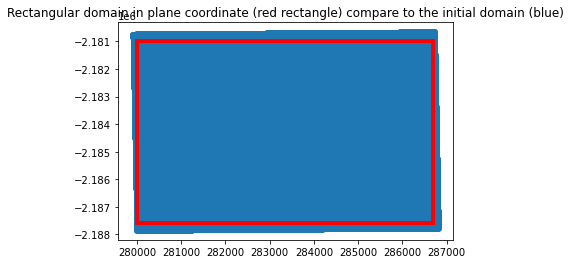

In [12]:
fig,ax=plt.subplots()
ax.scatter(x_utm, y_utm)
ax.add_patch( Rectangle((xo,yo),Dx,Dy,edgecolor='red',facecolor='none',lw=4))
plt.title('Rectangular domain in plane coordinate (red rectangle) compare to the initial domain (blue)')


### Getting the initial resolution

In [13]:
mindist=10**9
for i in range(0, len(x_utm)-1):
    dist=np.sqrt((x_utm[i+1]-x_utm[i])**2 + (y_utm[i+1]-y_utm[i])**2)
    mindist=np.minimum(mindist,dist)
mindist

9.433134032196659

### Interpolation on the new grid

In [14]:
nx = int(np.ceil(Dx/mindist))
ny = int(np.ceil(np.abs(Dy/mindist)))
X=np.linspace(xo, xf, nx)
Y=np.linspace(yo, yf, ny)
#Z=np.zeros(ny,nx)
#f= interpolate.interp2d(x_utm, y_utm, Zdeg, kind='cubic')

f= LinearNDInterpolator(list(zip(x_utm, y_utm)), Zdeg)
Xg,Yg=np.meshgrid(X, Y)
Z = f(Xg,Yg)

### Adjusting Z values
In code, the Z-axe direction is up, so we need to take the inverse of the Z values read.
We also choose to restrain the bathymetry to the interval $[-30,10]$ and set the point reference point $[0,0]$ at the bottom left corner.

In [15]:
Z=-Z
Z[Z<-30]=-30
Z[Z>10]=10
Xg=Xg-xo
Yg=Yg-yo
X=X-xo
Y=Y-yo

### Plot of the bathymetry

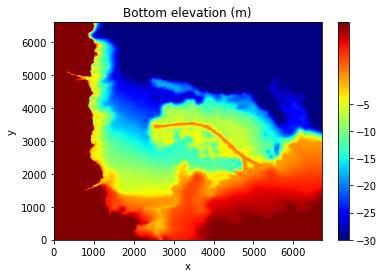

In [16]:
plt.pcolormesh(Xg,Yg,Z, shading='auto', cmap='jet')
plt.colorbar(ticks=range(-30, 0, 5))
plt.title('Bottom elevation (m)')
plt.ylabel('y')
plt.xlabel('x')
plt.savefig('bathymetry.png')
plt.show()
plt.close()

### Save the Bathymetry as a netCDF file
The bathymetry is then saved as a netCDF file, the prefered type for spacial input in BG_Flood.

In [17]:
ds = xr.Dataset(
      {"z": (("y", "x"), Z)},
      coords={
          "x": X,
          "y": Y,
      },
  )

ds.to_netcdf("bathy.nc")

# Creation of the forcing
In this configuration, the code will be forced using the offshore simulated free surface elevation time series (the “control point”).  The location of this time series is (lat,long)= [19.7576, 204.93]. This will be imposed on the top boundary.

## Writing the left boundary condition
The boundary condition file will be defined by a time serie of water elevation(s).
The first column contains the time variable, the following ones correspond to equally spaced values of water elevation along the boundary. (If there is only a second column, the water elevation will be constant along the boundary; two or more water elevation will correspond to equally spaced values (on increasing coordinate order) and the boundary condition will be linearly interpolate between these values). 

In this case, as we want to impose an elevation constant along the boundary, we will just use two lines (_t ,  h_). (Note that the final time of the forcing files should be larger than the final simulation time.)

### Reading the incident wave forcing

In [18]:
incidentWaveFile= os.path.join(dataDir,'incident_wave','se.dat')
[Tw,Zw] = readCSV_Ncol(incidentWaveFile,2,0)

Shift water elevation to a 0 reference and get forcing in second (initially in min)

In [19]:
Zwr=[]
Twr=[]
for i in range(len(Zw)):
    Zwr.append(Zw[i]-Zw[0])
    Twr.append(Tw[i]*60)

Add a zero elevation forcing at the end to run a longer simulation (simulation time is restricted by forcing times)

In [20]:
Twr.append(Twr[-1]+1)
Twr.append(Twr[-1]+7200)
Zwr.append(0.0)
Zwr.append(0.0)

Save in a text file

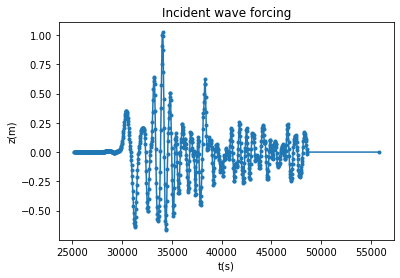

In [21]:
filename = "incident_wave_forcing.txt"
f=open(filename,'w')
for i in range(len(Zwr)):
    f.write('%f \t' % Twr[i])
    f.write('%f \n' % Zwr[i])
f.close()

plt.plot(Twr,Zwr,'.-')
plt.title('Incident wave forcing')
plt.ylabel('z(m)')
plt.xlabel('t(s)')
plt.savefig('wave-forcing.png')
plt.show()

## Location of the Gauge and ADCP in our coordinate system
The positions of the different mesurement device are defined and converted in our coordinate system:
* Offshore: reference gauge, outside of the harbour, which data as been used for the incident wave forcing
* TidalStat: Tidal station at the inside end of the harbour
* ADCP_Entrance: ADCP in the entrance channel of the harbour
* ADCP_Inside: ADCP inside the harbour (back of the mole)
* Forcing: Supplementary gauge added under the top boundary to verify the incidnt wave forcing

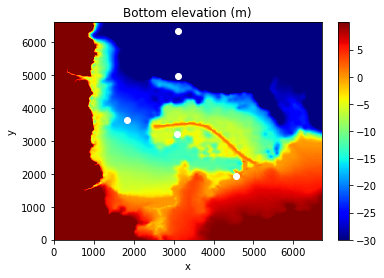

In [22]:
Offshore_deg=[19.7576,204.93]
#TidalStat_deg=[19.7308,204.9447]
TidalStat_deg=[19.7303,204.9444]
ADCP_Entrance_deg=[19.7452,204.9180]
ADCP_Inside_deg=[19.7417,204.9300]
Forcing_deg=[19.77,204.9300]

[x, y, utm_zone, utm_letter] = utm.from_latlon(Offshore_deg[0], Offshore_deg[1]-360)
Offshore_m=[x-xo,yf+y]
[x, y, utm_zone, utm_letter] = utm.from_latlon(TidalStat_deg[0], TidalStat_deg[1]-360)
TidalStat_m=[x-xo,yf+y]
[x, y, utm_zone, utm_letter] = utm.from_latlon(ADCP_Entrance_deg[0], ADCP_Entrance_deg[1]-360)
ADCP_Entrance_m=[x-xo,yf+y]
[x, y, utm_zone, utm_letter] = utm.from_latlon(ADCP_Inside_deg[0], ADCP_Inside_deg[1]-360)
ADCP_Inside_m=[x-xo,yf+y]
[x, y, utm_zone, utm_letter] = utm.from_latlon(Forcing_deg[0], Forcing_deg[1]-360)
Forcing_m=[x-xo,yf+y]

plt.pcolormesh(Xg,Yg, Z, shading='auto', cmap='jet')
plt.colorbar(ticks=range(-30, 10, 5))

plt.scatter(Offshore_m[0],Offshore_m[1],marker='o',color='white')
plt.scatter(TidalStat_m[0],TidalStat_m[1],marker='o',color='white')
plt.scatter(ADCP_Entrance_m[0],ADCP_Entrance_m[1],marker='o',color='white')
plt.scatter(ADCP_Inside_m[0],ADCP_Inside_m[1],marker='o',color='white')
plt.scatter(Forcing_m[0],Forcing_m[1],marker='o',color='white')
#plt.colorbar(ticks=range(-30, 10, 5))
plt.title('Bottom elevation (m)')
plt.ylabel('y')
plt.xlabel('x')
plt.savefig('bathymetry.png')
plt.show()
plt.close()

## Writing the BG_Params file
This text file is the main interface to BG_Flood. It contains a list of key words and associated values to modify
the default flow and grid and time keeping parameters, boundary and external forcing, as well as output options and reference values. Different keys can be accepted for the same parameter (see the documentation for a detailled list of the input parameters).
The minimum input is the bathymetry file. In this example, we will conserve a simple version of the BG_Params file where only the modified values will be listed.

In [23]:
key=[]
value=[]

* name of the bathymetry file (and variable name associated to altitude (here _z_) if the format is netCDF)

In [24]:
key.append('topofile')
value.append('bathy.nc?z')

* mask to remove parts of the domain with elevation over $5m$.

In [25]:
key.append('mask')
value.append('5.0')

* Timekeeping parameters
    * "totaltime"  : Start time for the simulation
    * "endtime" : End of simulation (in s)

In [26]:
key.append('totaltime')
value.append(Twr[0])
key.append('endtime')
value.append(Twr[-1])

* Resolution of the simulation (by default, the resolution of the bathy/topo file is used)

In [27]:
key.append('dx')
value.append(5.0)

* Choice of the GPU/CPU mode (-1 if no GPU else number of GPU)

In [28]:
#key.append('gpudevice')
#value.append(-1)

* Flow and models parameters (following benchmark advice models)
    * "frictionmodel": bottom friction model (-1: Manning model, 0:, 1: Smart model (default, __REF__))
    * cf: friction coefficient

In [29]:
key.append('frictionmdel')
value.append('-1')
key.append('cf')
value.append('0.025')

* Boundaries condition
Boundaries are refered by their position, using "top/bottom/right/left" keywords. They are associated to a boundary type 
( 0:wall; 1: Neumann (Default); 2:Dirichlet (zs); 3: abs1d) and possibly a file containing a time serie. In this case, the file name is placed before the type, coma-separated.


In [30]:
key.append('top')
value.append('incident_wave_forcing.txt,2')

* Outputs
The code can output 2D map of 2D fields in netCDF format and time series of water elevation.
    * "outputtimestep" : Time step for 2D fields outputs
    * "smallnc": to scaled and saved 2D fields as a short integer if 1 (default value)
    * "TSOutput": Time serie output, giving a file name and a (x,y) position (which will be converted to nearest grid position).
    This keyword can be used multiple times to extract time series at different locations.The data is stocked for each timestep and written by flocs in the file.

In [31]:
key.append('outputtimestep')
value.append('600')
key.append('smallnc')
value.append('0')
key.append('TSOutput')
mystr='TidalStat.txt,' + str(TidalStat_m[0]) +',' + str(TidalStat_m[1])
value.append(mystr)
key.append('TSOutput')
mystr='Offshore.txt,' + str(Offshore_m[0]) +',' + str(Offshore_m[1])
value.append(mystr)
key.append('TSOutput')
mystr='ADCP_Entrance.txt,' + str(ADCP_Entrance_m[0]) +',' + str(ADCP_Entrance_m[1])
value.append(mystr)
key.append('TSOutput')
mystr='ADCP_Inside.txt,' + str(ADCP_Inside_m[0]) +',' + str(ADCP_Inside_m[1])
value.append(mystr)
key.append('TSOutput')
mystr='Forcing.txt,' + str(Forcing_m[0]) +',' + str(Forcing_m[1])
value.append(mystr)

In [32]:
key

['topofile',
 'mask',
 'totaltime',
 'endtime',
 'dx',
 'frictionmdel',
 'cf',
 'top',
 'outputtimestep',
 'smallnc',
 'TSOutput',
 'TSOutput',
 'TSOutput',
 'TSOutput',
 'TSOutput']

In [33]:
value

['bathy.nc?z',
 '5.0',
 25200.0,
 55771.0,
 5.0,
 '-1',
 '0.025',
 'incident_wave_forcing.txt,2',
 '600',
 '0',
 'TidalStat.txt,4573.7262222575955,1941.7517201341689',
 'Offshore.txt,3101.0065357664134,4982.572003799956',
 'ADCP_Entrance.txt,1826.3262509590131,3625.1350853689946',
 'ADCP_Inside.txt,3079.5065653822385,3222.234926824458',
 'Forcing.txt,3117.7853643879644,6355.41538212914']

These data are then saved in a BG_Param.txt file.

In [34]:
data = np.column_stack([key, value])
datafile_path = "BG_param.txt"
np.savetxt(datafile_path , data, fmt=['%s ',' %s ;'], delimiter='=')

# Launching the code BG_flood
All the needed links to the libraries (.dll files) and the BG_flood executable are copied in the working folder.
The 

In [35]:
myFiles=[f for f in os.listdir(codeDir) if f.endswith(".dll")]
myFiles.append('BG_flood.exe')
for f in myFiles:
    origin=os.path.join(codeDir,f)
    destination=os.path.join(MyDir,f)
    shutil.copy(origin, destination) 

Launch of the code

In [ ]:
os.system('BG_flood.exe >> BG_out.txt')

# Comparaison of the data output with the benchmark data

## Reading the benchmark data

### Tide station

Text(0.5, 0, 'Time (s)')

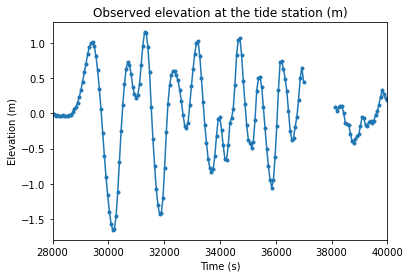

In [36]:
filename=os.path.join(dataDir,'comparison_data','TG_1617760_detided.txt')    
T1, H1 = readCSV_Ncol(filename,2,0)

fig,ax = plt.subplots(1,1)
ax.plot(T1,H1,'.-')
ax.set_xlim(28000,40000)
plt.title('Observed elevation at the tide station (m)')
plt.ylabel('Elevation (m)')
plt.xlabel('Time (s)')

### ADCP

In [37]:
filename = os.path.join(dataDir,'comparison_data','HAI1125_detided_harmonic.txt')
[Te, Ue, Ve]  = readCSV_Ncol(filename,3,0)
filename = os.path.join(dataDir,'comparison_data','HAI1126_detided_harmonic.txt')
[Ti, Ui, Vi]  = readCSV_Ncol(filename,3,0)

Get the ADCP data in second:

In [38]:
Te_s=[]
Ti_s=[]
for i in range(len(Te)):
    Te_s.append(Te[i]*3600)
for i in range(len(Ti)):
    Ti_s.append(Ti[i]*3600)

Text(0.5, 0, 'Time (s)')

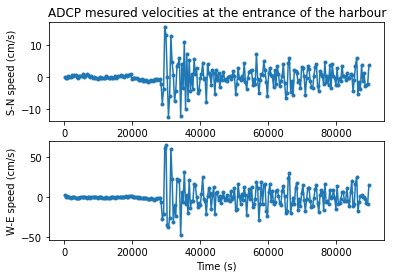

In [39]:
plt.subplot(2,1,1)
plt.plot(Te_s,Ue,'.-')
plt.ylabel('S-N speed (cm/s)')
plt.title('ADCP mesured velocities at the entrance of the harbour')
plt.subplot(2,1,2)
plt.plot(Te_s,Ve,'.-')
plt.ylabel('W-E speed (cm/s)')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

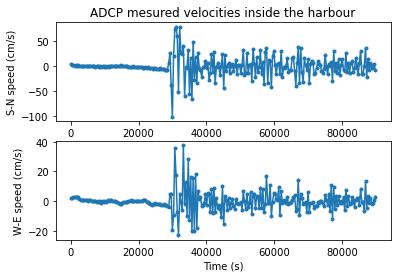

In [40]:
plt.subplot(2,1,1)
plt.plot(Ti_s,Ui,'.-')
plt.ylabel('S-N speed (cm/s)')
plt.title('ADCP mesured velocities inside the harbour')
plt.subplot(2,1,2)
plt.plot(Ti_s,Vi,'.-')
plt.ylabel('W-E speed (cm/s)')
plt.xlabel('Time (s)')

## Reading the BG_flood output
These time series contain:
* the time ($t$)
* the surface water elevation ($z_s$)
* the full water column elevation ($h$)
* the x-velocity (W-E) ($u$)
* the y-velocity (S-N) ($v$)

for each time step, at the nearest cell center to the coordinate indicated in the *BG_Params.txt* file.

In [42]:
Data_s = readCSV_Ncol('TidalStat.txt',5,1)
Data_o = readCSV_Ncol('Offshore.txt',5,1)
Data_i = readCSV_Ncol('ADCP_Inside.txt',5,1)
Data_e = readCSV_Ncol('ADCP_Entrance.txt',5,1)
Data_f = readCSV_Ncol('Forcing.txt',5,1)

## Comparing the simulation results with the observations

### Comparison of the water elevation at the Offshore Station

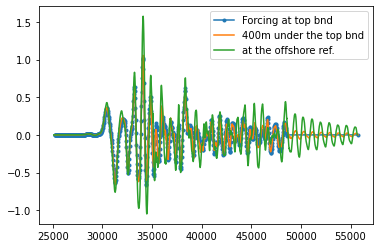

In [43]:
t_f=[]
t_o=[]
for i in range(len(Data_f[0])):
    t_f.append(Data_f[0][i]-17)
    t_o.append(Data_o[0][i]-93)
ax=plt.subplot(1,1,1)
P1,=ax.plot(Twr,Zwr,'.-', label='Forcing at top bnd')
P2,=ax.plot(t_f, Data_f[1], label='400m under the top bnd')
P3,=ax.plot(t_o, Data_o[1], label='at the offshore ref.')
plt.legend(handles=[P1, P2, P3])

### Comparison of the water elevation at the Tidal Station

In [44]:
t_s=[]
for i in range(len(Data_s[0])):
    t_s.append(Data_s[0][i]-1500)

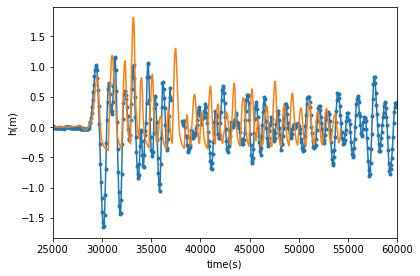

In [45]:
fig,ax = plt.subplots(1,1)
plt.rcParams['font.size'] = '12'
#plt.rcParams['font.weight'] = 'bold'


ax.plot(T1,H1,'.-')
ax.plot(t_s,Data_s[1],'-')
ax.set_xlim(25000,60000)
ax.set_ylabel('h(m)')
plt.xlabel('time(s)')
plt.tight_layout()
plt.savefig('results.png')
plt.show()

### Comparison of ADCP Data at the Entrance of the harbour
A swift in time is applied to the simulated data and the velocity is converted from m/s (output of the code) to cm/s as given in the benchmark data.

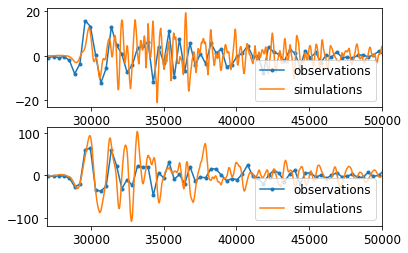

In [46]:
t_e=[]
u_e=[]
v_e=[]
for i in range(len(Data_e[0])):
    t_e.append(Data_e[0][i]-1500)
    u_e.append(Data_e[3][i]*100)
    v_e.append(Data_e[4][i]*100)

ax=plt.subplot(2,1,1)
P1,=ax.plot(Te_s,Ue,'.-', label='observations')
P2,=ax.plot(t_e, u_e, label='simulations')
ax.set_xlim(27000,50000)
#ax.
plt.legend(handles=[P1, P2])
ax=plt.subplot(2,1,2)
P1,=ax.plot(Te_s,Ve,'.-', label='observations')
P2,=ax.plot(t_e, v_e, label='simulations')
ax.set_xlim(27000,50000)
plt.legend(handles=[P1, P2])


### Comparison of ADCP Data at the Inside the harbour
As before, simulation outputs are shifted in time and converted to cm/s.

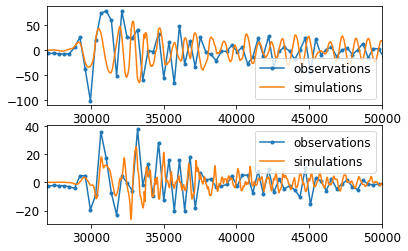

In [47]:
t_i=[]
u_i=[]
v_i=[]
for i in range(len(Data_i[0])):
    t_i.append(Data_i[0][i]-1500)
    u_i.append(Data_i[3][i]*100)
    v_i.append(Data_i[4][i]*100)

ax=plt.subplot(2,1,1)
P1,=ax.plot(Ti_s,Ui,'.-', label='observations')
P2,=ax.plot(t_i, u_i, label='simulations')
ax.set_xlim(27000,50000)
#ax.
plt.legend(handles=[P1, P2])
ax=plt.subplot(2,1,2)
P1,=ax.plot(Ti_s,Vi,'.-', label='observations')
P2,=ax.plot(t_i, v_i, label='simulations')
ax.set_xlim(27000,50000)
plt.legend(handles=[P1, P2])
